In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import importlib
import scripts.theodolite_function as tfu
import scipy.optimize as opti
import itertools
import scripts.liblie as ll

def T_z(x,y,z, theta):
    T = np.eye(4,4)
    T[:3,3] = np.array([x,y,z])
    
    C = ll.expm_so3(ll.wedge_so3(np.array([0,0,theta])))
    
    T[:3,:3] = C
    
    return T

def cost_fun(X, ps1, ps2):
    T = T_z(*X)
    c=0
    for i in range(ps1.shape[1]):
        p1 = ps1[:,i]
        p2 = ps2[:,i]
        c+= np.linalg.norm(p1-T@p2)**2
    return c/ps1.shape[1]

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


Python older than 3.7 detected. 


In [14]:
file_name = './data/total_station/20220711/theodolite_reference_prisms_geomatic.txt'
_, _, _, trimble_1, trimble_2, trimble_3, _, _, _ = tfu.read_marker_file_raw_data(file_name)
subsets = [[1,1,0,0],
          [1,0,1,0],
          [1,0,0,1],
          [0,1,1,0],
          [0,1,0,1],
          [0,0,1,1]]
method='TNC'
tol=1e-10
maxfun=500

pilier_A = np.array([0, 0, 0, 1]).T
pilier_B = np.array([0, np.sqrt(181.016**2 - 0.323**2), 0.323, 1])
pilier_C = np.array([0, np.sqrt(363.492**2 - 1.038**2), 1.038, 1])
pilier_D = np.array([0, np.sqrt(548.578**2 - 2.374**2), 2.374, 1])
plilier = np.array([pilier_A, pilier_B, pilier_C, pilier_D]).T

x0 = [0,0,0,np.pi/2.]

print(plilier)

errors1 = []
errors2 = []
errors3 = []

for sub in subsets:
    print(sub)
    mask = np.array(sub)  
    bmask = mask.astype(bool)
    
    pilier_t = plilier[:,bmask]
    pilier_c = plilier[:,~bmask]

    ps1 = trimble_1[:,bmask]
    ps2 = trimble_2[:,bmask]
    ps3 = trimble_3[:,bmask]

    ps1_c = trimble_1[:,~bmask]
    ps2_c = trimble_2[:,~bmask]
    ps3_c = trimble_3[:,~bmask]

    # print("TW1")
    res = opti.minimize(lambda X: cost_fun(X, pilier_t, ps1), x0=x0, method=method, tol=tol,
                       options={'maxfun':maxfun})
    print(res)
    print("residual = {} m/prism".format(np.sqrt(res.fun)))

    TW1 = T_z(*res.x)
    
    # print("TW2")
    res = opti.minimize(lambda X: cost_fun(X, pilier_t, ps2), x0=x0, method=method, tol=tol,
                       options={'maxfun':maxfun})
    print(res)
    print("residual = {} m/prism".format(np.sqrt(res.fun)))

    TW2 = T_z(*res.x)
    
    # print("TW3")
    res = opti.minimize(lambda X: cost_fun(X, pilier_t, ps3), x0=x0, method=method, tol=tol,
                       options={'maxfun':maxfun})
    print(res)
    print("residual = {} m/prism".format(np.sqrt(res.fun)))

    TW3 = T_z(*res.x)
    
    #============================================================
    #eval solution
    trimble_1_w = TW1@ps1_c
    trimble_2_w = TW2@ps2_c
    trimble_3_w = TW3@ps3_c
    
    verrors1 = pilier_c - trimble_1_w
    for i in range(verrors1.shape[1]):
        errors1 += [np.linalg.norm(verrors1[:,i])]
        
    verrors2 = pilier_c - trimble_2_w
    for i in range(verrors2.shape[1]):
        errors2 += [np.linalg.norm(verrors2[:,i])]
        
    verrors3 = pilier_c - trimble_3_w
    for i in range(verrors3.shape[1]):
        errors3 += [np.linalg.norm(verrors3[:,i])]
 

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.81015712e+02 3.63490518e+02 5.48572863e+02]
 [0.00000000e+00 3.23000000e-01 1.03800000e+00 2.37400000e+00]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00]]
[1, 1, 0, 0]
     fun: 1.5060253646120293e-05
     jac: array([-7.89125305e-07, -3.53274462e-07, -7.22422547e-08, -2.96292127e-09])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 1120
     nit: 46
  status: 1
 success: True
       x: array([-12.71485757, 290.21537218,   1.10116369,  -1.33831873])
residual = 0.003880754262526847 m/prism
     fun: 1.687509442191152e-05
     jac: array([-5.76053558e-08, -1.46401058e-09, -6.77626354e-12,  3.55516671e-09])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 810
     nit: 34
  status: 1
 success: True
       x: array([ -6.95420659, 288.98456322,   0.80657542,  -1.85788291])
residual = 0.00410793067394175 m/prism
     fun: 1.2541333198368335e-05
     jac: array([-2.13677867e-06,  1.12052

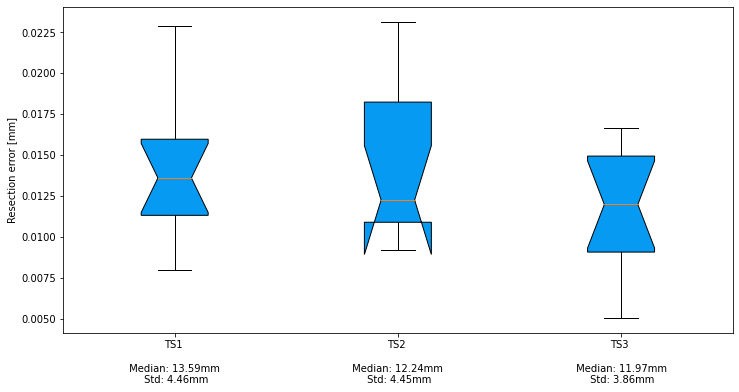

In [30]:
fig = plt.figure(figsize =(12, 6))
ax = fig.add_subplot(111)

box = ax.boxplot([errors1, errors2, errors3], notch=True, patch_artist=True, vert = 1, showfliers=False, showmeans=False)
plt.xticks([1, 2, 3], ["TS1 \n\n Median: "+str(round(np.median(errors1)*1000,2))+"mm \n Std: "+str(round(np.std(errors1)*1000,2))+"mm",
                       "TS2 \n\n Median: "+str(round(np.median(errors2)*1000,2))+"mm \n Std: "+str(round(np.std(errors2)*1000,2))+"mm",
                       "TS3 \n\n Median: "+str(round(np.median(errors3)*1000,2))+"mm \n Std: "+str(round(np.std(errors3)*1000,2))+"mm"])
colors_box = ['#069AF3', '#069AF3', '#069AF3']

for patch, color in zip(box['boxes'], colors_box):
    patch.set_facecolor(color)
        
ax.set_ylabel("Resection error [mm]")
plt.show()

<IPython.core.display.Javascript object>


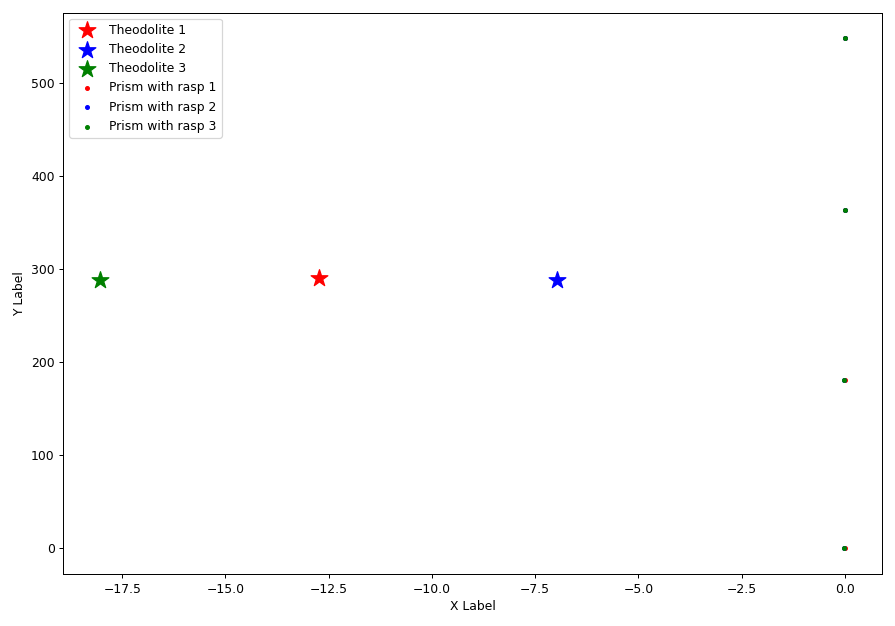

In [36]:
%matplotlib notebook
tfu.plot_trajectories_prism(3, TW1@trimble_1, TW2@trimble_2, TW3@trimble_3, TW1, TW2, TW3, 0, 0,"example.pdf",0)